# PREP

## TODO remove old code and repetitions

In [108]:
import os
import numpy as np
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

In [125]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
RESULTDIR = os.path.join(REPODIR, 'results')
# REPODIR = '/home/wimmerl/projects/wildlife-experiments'

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}
THRESHOLDS = [0.3, 0.5, 0.7, 0.9]
OUR_THRESH = 0.5
ITERATIONS = list(range(3))[1:]
RANDOM_SEEDS = os.listdir(os.path.join(RESULTDIR, 'coldstart'))

In [7]:
# FILES_INSAMPLE = [
#     os.path.join(RESULTDIR, '0', f) for f in os.listdir(os.path.join(RESULTDIR, '0')) if 'insample_val' in f
# ]
# FILES_INSAMPLE = [os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'insample_test' in f]
# RESULTS_INSAMPLE = [load_pickle(f) for f in FILES_INSAMPLE]
# THRESHOLDS = [0.1]

## DATA

In [126]:
FILES_INSAMPLE = [
    [os.path.join(RESULTDIR, t, f) for f in os.listdir(os.path.join(RESULTDIR, t)) if 'insample_test' in f] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)))) 
    if 'oosample' in f 
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'active_optimal' in f 
]
# FILES_ACTIVE_COLDSTART = [
#     [os.path.join(RESULTDIR, 'coldstart', rs, f) for f in os.listdir(os.path.join(RESULTDIR, 'coldstart', rs))]
#     for rs in os.listdir(os.path.join(RESULTDIR, 'coldstart'))
# ]
FILES_ACTIVE_COLDSTART = [os.path.join(RESULTDIR, 'coldstart', rs) for rs in RANDOM_SEEDS]

In [118]:
# custom averaging functions accounting for specific ordering
def average_results(dict_list_preds, list_truth):
    ordered_dicts = [{k: d[k] for k in sorted(list(d.keys()))} for d in dict_list_preds]
    ordered_arrays = [
        np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(d.values())]) for d in ordered_dicts
    ]
    ordered_lists = [
        [x[k] for k in [list(d.keys()).index(i) for i in sorted(list(d.keys()))] ]
        for x, d in zip(list_truth, dict_list_preds)
    ]
    return reduce(np.add, ordered_arrays) / len(dict_list_preds), ordered_lists[0]

In [127]:
results_insample_avg = {}
results_oosample_avg = {}
results_active_optimal_avg = {}
results_active_coldstart_avg = {}

for idx, t in enumerate(THRESHOLDS):
    results_t = [load_pickle(f) for f in FILES_INSAMPLE[idx]]
#     results_t = [r[t] for r in RESULTS_INSAMPLE]
#     results_t = RESULTS_INSAMPLE
    preds_imgs_clf_t, truth_imgs_clf_t = average_results(
        [r['preds_imgs_clf'] for r in results_t], [r['truth_imgs_clf'] for r in results_t]
    )
    preds_imgs_ppl_t, truth_imgs_ppl_t = average_results(
        [r['preds_imgs_ppl'] for r in results_t], [r['truth_imgs_ppl'] for r in results_t]
    )
    results_insample_avg.update(
        {
            t: {
                'preds_imgs_clf': preds_imgs_clf_t,
                'preds_imgs_ppl': preds_imgs_ppl_t,
                'truth_imgs_clf': truth_imgs_clf_t,
                'truth_imgs_ppl': truth_imgs_ppl_t
                
            }
        }
    )
results_oos = [load_pickle(f) for f in FILES_OOSAMPLE]
preds_imgs_clf, truth_imgs_clf = average_results(
    [r['preds_imgs_clf'] for r in results_oos], [r['truth_imgs_clf'] for r in results_oos]
)
preds_imgs_ppl, truth_imgs_ppl = average_results(
    [r['preds_imgs_ppl'] for r in results_oos], [r['truth_imgs_ppl'] for r in results_oos]
)
results_oosample_avg.update(
    {
        'preds_imgs_clf': preds_imgs_clf,
        'preds_imgs_ppl': preds_imgs_ppl,
        'truth_imgs_clf': truth_imgs_clf,
        'truth_imgs_ppl': truth_imgs_ppl

    }
)
results_al_opt = [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]
preds_imgs_clf, truth_imgs_clf = average_results(
    [r['preds_imgs_clf'] for r in results_al_opt], [r['truth_imgs_clf'] for r in results_al_opt]
)
preds_imgs_ppl, truth_imgs_ppl = average_results(
    [r['preds_imgs_ppl'] for r in results_al_opt], [r['truth_imgs_ppl'] for r in results_al_opt]
)
results_active_optimal_avg.update(
    {
        'preds_imgs_clf': preds_imgs_clf,
        'preds_imgs_ppl': preds_imgs_ppl,
        'truth_imgs_clf': truth_imgs_clf,
        'truth_imgs_ppl': truth_imgs_ppl

    }
)
for t in ITERATIONS:
    results_t = [
        load_pickle(os.path.join(FILES_ACTIVE_COLDSTART[rs], f'results_iteration_{t}.pkl')) 
        for rs, _ in enumerate(RANDOM_SEEDS)
    ]
    preds_imgs_clf_t, truth_imgs_clf_t = average_results(
        [r['preds_imgs_clf'] for r in results_t], [r['truth_imgs_clf'] for r in results_t]
    )
    preds_imgs_ppl_t, truth_imgs_ppl_t = average_results(
        [r['preds_imgs_ppl'] for r in results_t], [r['truth_imgs_ppl'] for r in results_t]
    )
    results_active_coldstart_avg.update(
        {
            t: {
                'preds_imgs_clf': preds_imgs_clf_t,
                'preds_imgs_ppl': preds_imgs_ppl_t,
                'truth_imgs_clf': truth_imgs_clf_t,
                'truth_imgs_ppl': truth_imgs_ppl_t
                
            }
        }
    )

# IN-SAMPLE

In [55]:
# RESULTS_INSAMPLE_TEST_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_TEST_05 = load_pickle('results/202302280915_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_05 = load_pickle('results/202302280915_insample_val.pkl')

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [64]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
RESULT_FILE = results_insample_avg
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [65]:
rows_multiclass = []
rows_empty = []

for t in sorted(THRESHOLDS):
    result = RESULT_FILE[t]
    y_true = result[TRUTH]
    y_pred = [np.argmax(v) for v in result[PREDS]]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    rows_multiclass.append(
        [
            t,
            report['accuracy'], 
            report['weighted avg']['precision'], 
            report['weighted avg']['recall'], 
            report['weighted avg']['f1-score']
        ]    
    )
    conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
    rows_empty.append(
        [
            t,
            (conf_empty[0][0, 0] + conf_empty[0][1, 1]) / conf_empty.sum(),
            report['empty']['precision'],
            report['empty']['recall'],
            report['empty']['f1-score'],
        ]
    )
df_ins_multiclass = pd.DataFrame(rows_multiclass, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])
df_ins_empty = pd.DataFrame(rows_empty, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])

In [66]:
df_ins_multiclass.sort_values('threshold')  # Table 3

,threshold,acc,prec,rec,fone
0,0.3,0.934081,0.930351,0.934081,0.930055
1,0.5,0.928337,0.924400,0.928337,0.924822
2,0.7,0.931619,0.926862,0.931619,0.926799
3,0.9,0.928884,0.924045,0.928884,0.922367


In [67]:
df_ins_empty.sort_values('threshold')  # Table 2

,threshold,acc,prec,rec,fone
0,0.3,0.955416,0.947862,0.985182,0.966162
1,0.5,0.950219,0.944173,0.980948,0.962209
2,0.7,0.953775,0.941603,0.989839,0.965119
3,0.9,0.951313,0.935060,0.993649,0.963465


## PERFORMANCE

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      2362
european_hare       0.94      0.72      0.81        64
       others       0.56      0.43      0.49       144
     red_deer       1.00      0.71      0.83         7
      red_fox       0.91      0.74      0.82        99
 red_squirrel       0.93      0.83      0.88        47
     roe_deer       0.93      0.93      0.93       904
    wild_boar       0.88      0.52      0.65        29

     accuracy                           0.93      3656
    macro avg       0.89      0.73      0.80      3656
 weighted avg       0.92      0.93      0.92      3656



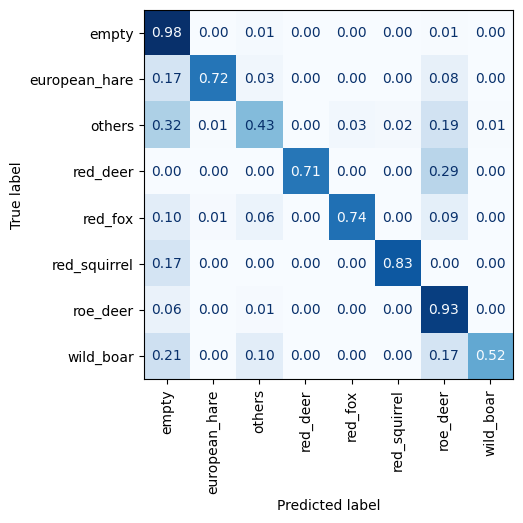

In [68]:
result_ours = results_insample_avg[OUR_THRESH]
y_true = result_ours['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in result_ours['preds_imgs_ppl']]
report = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys())
)
print(report)  # Figure 3
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

# OUT-OF-SAMPLE

## PERFORMANCE

In [94]:
y_true = results_oosample_avg['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in results_oosample_avg['preds_imgs_ppl']]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
rows = []
rows.append(
    [
        report_dict['accuracy'], 
        report_dict['weighted avg']['precision'], 
        report_dict['weighted avg']['recall'], 
        report_dict['weighted avg']['f1-score']
    ]
)

In [97]:
rows

[[0.8899803536345776,
  0.8826703383490069,
  0.8899803536345776,
  0.8821742046475819]]

In [99]:
acc_al_lower_limit, rec_al_lower_limit = rows[0][0], rows[0][1]

In [95]:
df_oos_multiclass = pd.DataFrame(
    rows,
    columns=['acc', 'prec', 'rec', 'fone']
)
df_multiclass = pd.concat([df_ins_multiclass.loc[df_ins_multiclass['threshold'] == OUR_THRESH], df_oos_multiclass])
df_multiclass.index = ['ins', 'oos']

In [96]:
df_multiclass.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.928337,0.92440,0.928337,0.924822
oos,0.889980,0.88267,0.889980,0.882174


               precision    recall  f1-score   support

        empty       0.94      0.96      0.95      2138
european_hare       0.68      0.46      0.55        37
       others       0.44      0.26      0.33       159
     red_deer       0.00      0.00      0.00        12
      red_fox       0.38      0.65      0.48        17
 red_squirrel       0.09      0.50      0.15         2
     roe_deer       0.86      0.92      0.89      1042
    wild_boar       0.93      0.54      0.68       156

     accuracy                           0.89      3563
    macro avg       0.54      0.54      0.50      3563
 weighted avg       0.88      0.89      0.88      3563



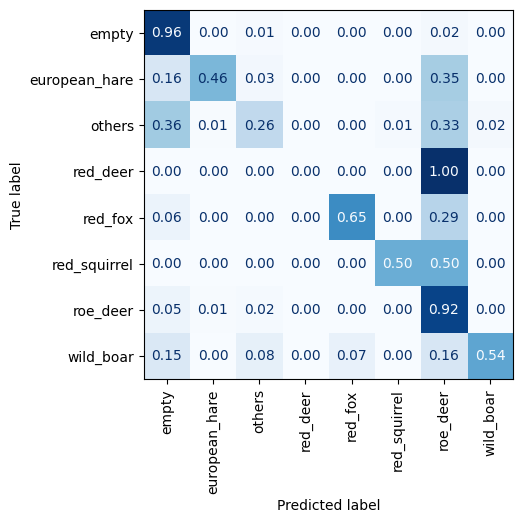

In [72]:
print(  # Figure 5
    classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

## ACTIVE LEARNING

In [100]:
y_true = results_active_optimal_avg['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in results_active_optimal_avg['preds_imgs_ppl']]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      2138
european_hare       1.00      0.62      0.77        37
       others       0.85      0.38      0.52       159
     red_deer       0.71      0.42      0.53        12
      red_fox       0.93      0.76      0.84        17
 red_squirrel       1.00      1.00      1.00         2
     roe_deer       0.91      0.94      0.92      1042
    wild_boar       0.96      0.82      0.89       156

     accuracy                           0.93      3563
    macro avg       0.91      0.74      0.80      3563
 weighted avg       0.93      0.93      0.92      3563



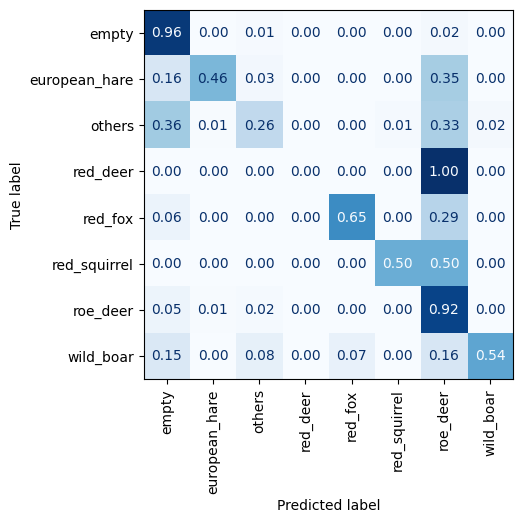

In [73]:
print(  # Figure 5
    classification_report(
        y_true=results_active_optimal_avg['truth_imgs_ppl'], 
        y_pred=[np.argmax(v) for v in results_active_optimal_avg['preds_imgs_ppl']],
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

## <font color='red'>PUT IN REAL N_SAMPLES</font>

In [128]:
ITERATIONS

[1, 2]

In [129]:
# compute relative sample size per iteration (sizes hard-coded for training)
# n_samples_total = 23491
# num_max_batches = (
#     (n_samples_total - (5 * 128 + 5 * 256 + 5 * 512)) // 1024
# )
# size_last_batch = (
#     n_samples_total - (5 * 128 + 5 * 256 + 5 * 512 + num_max_batches * 1024)
# )
# batch_sizes = (
#     5 * [128] + 5 * [256] + 5 * [512] + num_max_batches * [1024]
# )
# if size_last_batch > 0:
#     batch_sizes.append(size_last_batch)
batch_sizes = [512, 512]
batch_sizes_cs = np.cumsum([x / n_samples_total for x in batch_sizes])

In [131]:
acc_coldstart, rec_coldstart = [], []
# acc_warmstart, rec_warmstart = [], []

for i in ITERATIONS:
    y_true_cs = results_active_coldstart_avg[i]['truth_imgs_ppl']
    y_pred_cs = [np.argmax(v) for v in results_active_coldstart_avg[i]['preds_imgs_ppl']]
    report_dict_cs = classification_report(
        y_true=y_true_cs, 
        y_pred=y_pred_cs,
        target_names=list(LABEL_MAP.keys()),
        output_dict=True,
        zero_division=0
    )
#     y_true_ws = results_active_warmstart_avg[i]['truth_imgs_ppl']
#     y_pred_ws = [np.argmax(v) for v in results_active_warmstart_avg[i]['preds_imgs_ppl']]
#     report_dict_ws = classification_report(
#         y_true=y_true_ws, 
#         y_pred=y_pred_ws,
#         target_names=list(LABEL_MAP.keys()),
#         output_dict=True,
#         zero_division=0
#     )
    acc_coldstart.append(report_dict_cs['accuracy'])
    rec_coldstart.append(report_dict_cs['weighted avg']['recall'])
#     acc_warmstart.append(report_ws['accuracy'])
#     rec_warmstart.append(report_ws['weighted avg']['recall'])

In [132]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart))],
    'acc_coldstart': acc_coldstart,
#     'acc_warmstart': acc_warmstart
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart))],
    'rec_coldstart': rec_coldstart,
#     'rec_warmstart': rec_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec_pd = pd.DataFrame(al_perf_rec)

In [134]:
al_perf_acc_pd

,relative_size,acc_lower_limit,acc_upper_limit,acc_coldstart
0,0.028444,0.88998,0.929834,0.841987
1,0.056889,0.88998,0.929834,0.847600


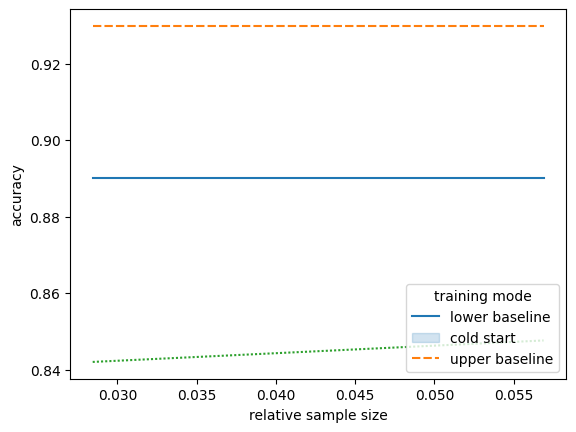

In [133]:
plt = sns.lineplot(
    data=pd.melt(al_perf_acc_pd, id_vars='relative_size'),
    x='relative_size',
    y='value',
    hue='variable',
    style='variable'
)
plt.set(xlabel='relative sample size', ylabel='accuracy')
plt.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'cold start', 'upper baseline']  # , 'warm start']
)